In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np

#import pyphysio
import pyphysio as ph
import pandas as pd
import pyphysio.filters.Filters as flt

# (should) show plots in a separate window
%matplotlib inline

Please cite:
Bizzego et al. (2019) 'pyphysio: A physiological signal processing library for data science approaches in physiology', SoftwareX


In [2]:
# open file
df_EDA = pd.read_csv('EDA_pp47.csv', header=None)

In [3]:
n_of_rows = df_EDA.count()
print(n_of_rows)

0    18306
dtype: int64


In [4]:
#actual recording time 60 mins = 3600s
#3600*4=n_rows
n_of_rows_keep = 3600*4
print(n_of_rows_keep)

14400


In [5]:
#using pandas to drop all the rows / seconds after 3540s 
#[n_of_rows_keep:n_of_rows]
df_EDA = df_EDA.drop(df_EDA.index[14400:18306])
print(df_EDA)

              0
0      0.000000
1      0.354758
2      0.434162
3      0.434162
4      0.436724
...         ...
14395  0.306357
14396  0.305077
14397  0.308919
14398  0.306357
14399  0.307638

[14400 rows x 1 columns]


In [6]:
# create the signal
fsamp = 4 #Hz
tstart_df_EDA = 0 #s


eda = ph.EvenlySignal(values = df_EDA.values.ravel(), 
                      sampling_freq = fsamp,
                      start_time = tstart_df_EDA)

In [7]:
#count n of rows to get time of recording (s) 
n_of_rows_keep = df_EDA.count()
print(n_of_rows_keep)
#walk time in seconds 
walk_time_seconds = n_of_rows_keep/4
print(walk_time_seconds)
#walk time in minutes
walk_time_minutes = walk_time_seconds/60
print(walk_time_minutes)

# save data 
outputFile=open("time_pp47.txt", 'a')
outputFile.write("{}\n{}\n".format(walk_time_seconds, walk_time_minutes))
outputFile.close()


0    14400
dtype: int64
0    3600.0
dtype: float64
0    60.0
dtype: float64


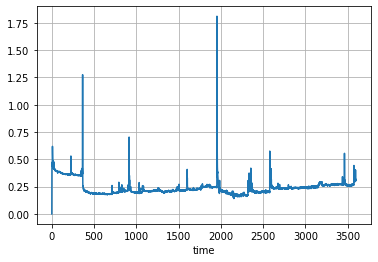

In [8]:
# plot
plot = eda.plot()
# plt.show() #using matplotlib to show the plot

In [9]:
#your signal is quite noisy (moving artifacts)
#consider the possibility of filtering it

#e.g. simple moving average filter
mov_avg = flt.ConvolutionalFilter('rect', win_len = 1)
eda = mov_avg(eda)

#however, check that you are not losing information


In [10]:
#THIS IS CORRECT
#create baseline (10mins) / label variable
#[0s-600s] #baseline 
#[600s -3480s] #actual recording session 

label = np.zeros(3600)#s
label[0:600] = 1
label[600:3600] = 2 

label = ph.EvenlySignal(label, sampling_freq = 1, signal_type = 'label')

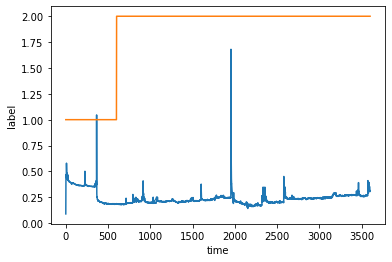

In [11]:
#see also the plots
eda.plot()
label.plot()

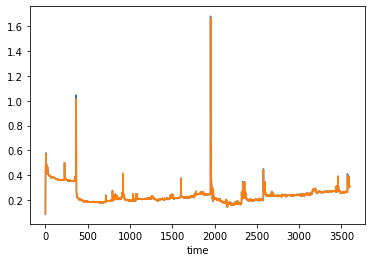

In [12]:
## filtering 
eda_filt = ph.IIRFilter(fp=0.8, fs=1.1, ftype='ellip')(eda)

eda.plot()
eda_filt.plot()

In [13]:
eda = eda_filt

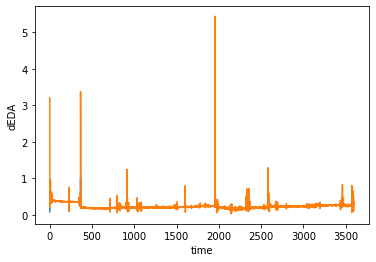

In [14]:
## estimate the driver function 
driver = ph.DriverEstim(t1=.75, t2=2)(eda)
eda.plot()
driver.plot()

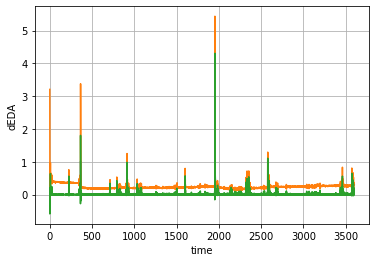

In [15]:
## compute tonic and phasic components
phasic, tonic, tmp_ = ph.PhasicEstim(delta=0.02)(driver)
eda.plot()
driver.plot()
phasic.plot()

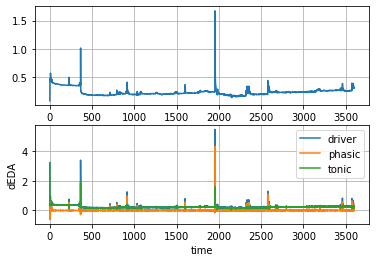

In [16]:
# check results so far
plt.figure() 
ax1 = plt.subplot(211)
eda.plot()
plt.subplot(212, sharex = ax1)
driver.plot()
phasic.plot()
tonic.plot()
plt.legend(['driver', 'phasic', 'tonic'])
plt.show()

In [17]:
## define a list of indicators
indicators_eda = [ph.Mean(name='PhaMean'),
                  ph.StDev(name='StDev'),
                  ph.AUC(name='AUC'),
                  ph.PeaksMean(name='PeaksMean', delta=0.02), 
                  ph.DurationMean(name='DurMean', delta=0.02)]

# you can also use other indicators, however, my suggestion would be to keep it simple and use the usual ones (mean, maximum, range etc)

In [18]:
#fixed length windowing
fixed_length = ph.FixedSegments(step = 60, width = 60, labels = label)                 
                  
## compute indicators of phasic signal
#pha_ind, col_names = ph.fmap(fixed_length, ph.preset_phasic(delta=0.02), phasic) #you should use the indicators you listed before
pha_ind, col_names = ph.fmap(fixed_length, indicators_eda, phasic) #you should use the indicators you listed before

In [19]:
#save results into a dataframe
phasic_indicators = pd.DataFrame(pha_ind, columns=col_names)

In [20]:
phasic_indicators.head()

,begin,end,label,PhaMean,StDev,AUC,PeaksMean,DurMean
0,0.0,60.0,1.0,0.024440,0.106550,1.466420,0.128487,1.383333
1,60.0,120.0,1.0,0.000247,0.003795,0.014791,0.021205,1.500000
2,120.0,180.0,1.0,0.000273,0.003030,0.016358,0.013988,1.500000
3,180.0,240.0,1.0,0.017534,0.078608,1.052061,0.393136,1.500000
4,240.0,300.0,1.0,-0.000039,0.004520,-0.002366,0.017976,1.500000


In [21]:
phasic_indicators.to_csv('phasicindicators_pp47.csv')